#### Predictive model to anticipate timely maintinance of devices based on daily telemetry 

- Goals : Maintenance cost reduction through predictive techniques
- Data source : http://aws-proserve-data-science.s3.amazonaws.com/predictive_maintenance.csv


##### Summary of the dataset
- Number of total observations: 124494
- Unique ids (unique device sensors): Total 1169 (No failure 1063, With failure 106)
- Length of observations varies from 1 to 304



##### Challenges
- Some sensors have intermintant measurements and difficult to obtain correct estimate in rolling window

##### References for background and modeling approaches
- https://github.com/aws-samples/amazon-sagemaker-architecting-for-ml/blob/master/Writeups/Predictive_Maintenance.md
- https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/cortana-analytics-playbook-predictive-maintenance

In [18]:
## libraries

import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns


## plotting
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
%matplotlib inline

## data
url = r'http://aws-proserve-data-science.s3.amazonaws.com/predictive_maintenance.csv'


In [3]:
## Read the data and perform QC

maintain_df = pd.read_csv(url)


## covert data to datetime
maintain_df['date'] = pd.to_datetime(maintain_df['date'], format="%Y-%m-%d")
#maintain_df = maintain_df.set_index('date')
#opsd_daily.head(3)
#maintain_df['date'] = maintain_df['date'].values.astype(float)
print(maintain_df.shape)
print(maintain_df['id'].nunique())
maintain_df.head()

(124494, 12)
1169


,date,id,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [4]:
maintain_df.describe()

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


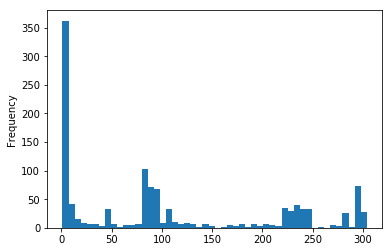

In [5]:
count_id = maintain_df.groupby(['id'])['failure'].count().sort_values(ascending=False)

count_id.plot.hist(bins=50)

##### Distribution of sample with and without failures (Number of TOTAL OBSERVATIONS)

             count      nunique
count  1169.000000  1169.000000
mean    106.496151     1.090676
std     102.651601     0.287270
min       1.000000     1.000000
25%       6.000000     1.000000
50%      84.000000     1.000000
75%     224.000000     1.000000
max     304.000000     2.000000


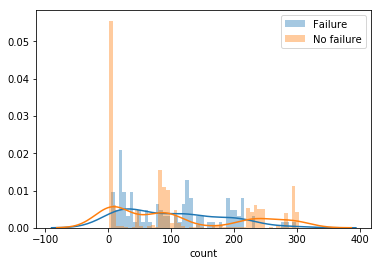

In [6]:
count_id = pd.DataFrame(maintain_df.groupby(['id'])['failure'].agg(['count','nunique']).sort_values(by='nunique',ascending=False))

print(count_id.describe())
sns.distplot(count_id[count_id['nunique']==2]['count'], hist=True, bins=50, rug=False, label='Failure')
sns.distplot(count_id[count_id['nunique']==1]['count'], hist=True, bins=50, rug=False, label='No failure')
plt.legend()

In [7]:
print(count_id.groupby('nunique')['nunique'].count())
count_id.head(10)

nunique
1    1063
2     106
Name: nunique, dtype: int64


,count,nunique
id,,
Z1F0LSNZ,177,2
W1F1230J,14,2
Z1F0P5D9,36,2
S1F0L0DW,141,2
W1F1DQN8,212,2
S1F0JGJV,278,2
S1F0JD7P,99,2
S1F0J5JH,193,2
Z1F0QH0C,83,2


In [8]:
#### Last day statistics

count_id = pd.DataFrame(maintain_df.groupby(['id'],as_index=False).agg(['last']))
count_id.columns = count_id.columns.droplevel(1) 
print(count_id.shape)
count_id.tail()
print(count_id.groupby('failure')['failure'].count())

(1169, 11)
failure
0    1068
1     101
Name: failure, dtype: int64


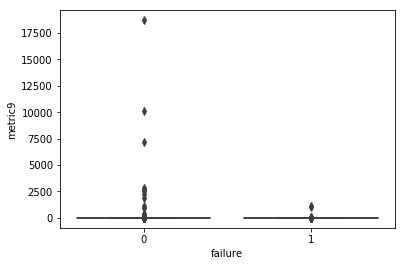

In [9]:
#### Plot the last day statistics between failure and no failure

ax = sns.boxplot(x="failure", y="metric9", data=count_id)
#count_id[]

In [10]:
maintain_df[maintain_df['id']=='S1F12ZRR'].head(10)
#print(maintain_df.columns)

,date,id,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
461,2015-01-01,S1F12ZRR,0,54680184,0,0,0,8,229384,0,0,0
1624,2015-01-02,S1F12ZRR,0,71582792,0,0,0,8,230696,0,0,0
2787,2015-01-03,S1F12ZRR,0,89963264,0,0,0,8,231976,0,0,0
3950,2015-01-04,S1F12ZRR,0,107084896,0,0,0,8,233347,0,0,0
5111,2015-01-05,S1F12ZRR,0,126752624,0,0,0,8,234656,0,0,0
6231,2015-01-06,S1F12ZRR,0,146804768,0,0,0,8,235941,0,0,0
7180,2015-01-07,S1F12ZRR,0,164153344,0,0,0,8,237298,0,0,0
7945,2015-01-08,S1F12ZRR,0,181750880,0,0,0,8,238615,0,0,0
8701,2015-01-09,S1F12ZRR,0,199191960,0,0,0,8,239931,0,0,0
9457,2015-01-10,S1F12ZRR,0,216828408,0,0,0,8,241285,0,0,0


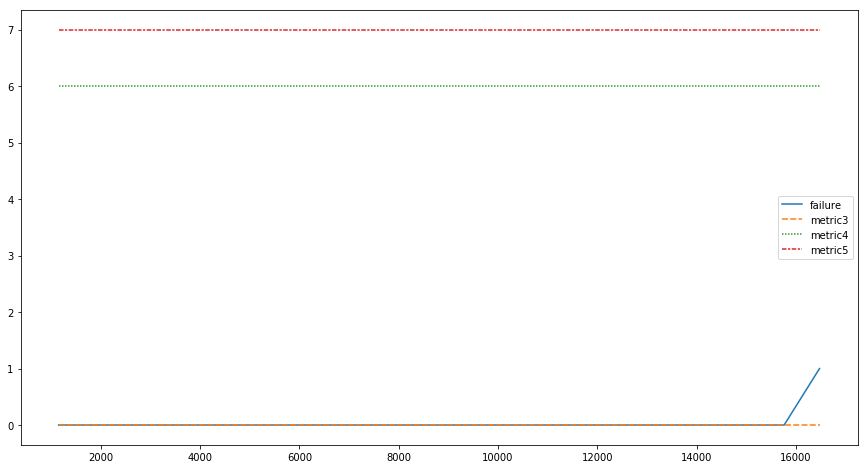

In [11]:
## plot the raw values 

subset_df = maintain_df[maintain_df['id']=='Z1F1FCH5']
subset_df = subset_df.drop(['id','date','metric1', 'metric2','metric8', 'metric6', 'metric7', 'metric9'], axis=1)

col_select = subset_df.columns
wide_df = subset_df[col_select]

# figure size
plt.figure(figsize=(15,8))

# timeseries plot using lineplot
ax = sns.lineplot(data=wide_df)

#ax.set_title('Un-normalized value of calories and different activities')

##### Feature engineering for rolling windows

In [12]:
## Calculate rolling mean values for telemetry features
temp = []
features = ['metric' + str(x) for x in range(1,10)]
for col in features:
    temp.append(pd.pivot_table(maintain_df,
                               index='date',
                               columns='id',
                               values=col).rolling(window=5).mean().unstack())
    
maintain_mean_5d = pd.concat(temp, axis=1)
maintain_mean_5d.columns = [i + '_mean_5d' for i in features]
maintain_mean_5d.reset_index(inplace=True)
maintain_mean_5d = maintain_mean_5d.loc[-maintain_mean_5d['metric1_mean_5d'].isnull()]
maintain_mean_5d.head()

"""
## Calculate rolling stdev values for telemetry features

temp = []
features = ['metric' + str(x) for x in range(1,10)]
for col in features:
    temp.append(pd.pivot_table(maintain_df,
                               index='date',
                               columns='id',
                               values=col).rolling(window=5).std().unstack())
    
maintain_sd_5d = pd.concat(temp, axis=1)
maintain_sd_5d.columns = [i + '_sd_5h' for i in features]
maintain_sd_5d.reset_index(inplace=True)
maintain_sd_5d = maintain_sd_5d.loc[-maintain_sd_5d['metric1_sd_5h'].isnull()]
maintain_sd_5d.head()
"""

"\n## Calculate rolling stdev values for telemetry features\n\ntemp = []\nfeatures = ['metric' + str(x) for x in range(1,10)]\nfor col in features:\n    temp.append(pd.pivot_table(maintain_df,\n                               index='date',\n                               columns='id',\n                               values=col).rolling(window=5).std().unstack())\n    \nmaintain_sd_5d = pd.concat(temp, axis=1)\nmaintain_sd_5d.columns = [i + '_sd_5h' for i in features]\nmaintain_sd_5d.reset_index(inplace=True)\nmaintain_sd_5d = maintain_sd_5d.loc[-maintain_sd_5d['metric1_sd_5h'].isnull()]\nmaintain_sd_5d.head()\n"

In [13]:

"""
## Merge telemetry features

telemetry_df = pd.concat([maintain_mean_5d,maintain_sd_5d.iloc[2:len(maintain_sd_5d.columns)]]).dropna()

telemetry_df.describe()
"""


'\n## Merge telemetry features\n\ntelemetry_df = pd.concat([maintain_mean_5d,maintain_sd_5d.iloc[2:len(maintain_sd_5d.columns)]]).dropna()\n\ntelemetry_df.describe()\n'

In [20]:
## Engineer the label 'failure'

failure_df = maintain_df[['id','date','failure']]
failure_df['failure'] = failure_df['failure'].replace({ 0:np.nan})
failure_df.head()

D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,id,date,failure
0,S1F01085,2015-01-01,NaN
1,S1F0166B,2015-01-01,NaN
2,S1F01E6Y,2015-01-01,NaN
3,S1F01JE0,2015-01-01,NaN
4,S1F01R2B,2015-01-01,NaN


In [29]:
## Merge rolling mean dataframe with failure information
labeled_df = maintain_mean_5d.merge(failure_df, on=['id','date'], how='left')

## backfill the number of days before failure as '1' and the remaining NaN as '0'
labeled_df['failure'] = labeled_df['failure'].fillna(method='bfill', limit=2)
labeled_df['failure'] = labeled_df['failure'].fillna(0)
labeled_df.head(20)

,id,date,metric1_mean_5d,metric2_mean_5d,metric3_mean_5d,metric4_mean_5d,metric5_mean_5d,metric6_mean_5d,metric7_mean_5d,metric8_mean_5d,metric9_mean_5d,failure
0,S1F01085,2015-01-05,113353115.2,56.0,0.0,52.0,6.0,407573.4,0.0,0.0,7.0,0.0
1,S1F01085,2015-01-06,95993406.4,56.0,0.0,52.0,6.0,407966.6,0.0,0.0,7.0,0.0
2,S1F013BB,2015-05-10,120718638.4,0.0,0.0,0.0,5.0,688993.0,0.0,0.0,0.0,0.0
3,S1F013BB,2015-05-11,140947182.4,0.0,0.0,0.0,5.0,689034.8,0.0,0.0,0.0,0.0
4,S1F0166B,2015-01-05,127506627.2,0.0,3.0,0.0,6.0,403301.8,0.0,0.0,0.0,0.0
5,S1F0166B,2015-01-06,116720849.6,0.0,3.0,0.0,6.0,403624.2,0.0,0.0,0.0,0.0
6,S1F01E6Y,2015-01-05,166870601.6,0.0,0.0,0.0,12.0,239990.0,0.0,0.0,0.0,0.0
7,S1F01E6Y,2015-01-06,139664108.8,0.0,0.0,0.0,12.0,241286.2,0.0,0.0,0.0,0.0
8,S1F01E6Y,2015-01-07,113530464.0,0.0,0.0,0.0,12.0,242584.0,0.0,0.0,0.0,0.0
9,S1F01E6Y,2015-01-08,87244264.0,0.0,0.0,0.0,12.0,243878.4,0.0,0.0,0.0,0.0


In [30]:
labeled_df[labeled_df['id']=='S1F023H2'].tail()

,id,date,metric1_mean_5d,metric2_mean_5d,metric3_mean_5d,metric4_mean_5d,metric5_mean_5d,metric6_mean_5d,metric7_mean_5d,metric8_mean_5d,metric9_mean_5d,failure
381,S1F023H2,2015-01-15,178983356.8,0.0,0.0,1.0,19.0,507985.6,16.0,16.0,3.0,0.0
382,S1F023H2,2015-01-16,200855545.6,0.0,0.0,1.0,19.0,509241.4,16.0,16.0,3.0,0.0
383,S1F023H2,2015-01-17,173656929.6,0.0,0.0,1.0,19.0,510526.6,16.0,16.0,3.0,1.0
384,S1F023H2,2015-01-18,146419452.8,0.0,0.0,1.0,19.0,511676.8,16.0,16.0,3.0,1.0
385,S1F023H2,2015-01-19,118570489.6,0.0,0.0,1.0,19.0,512759.0,16.0,16.0,3.0,1.0
